In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from project import run

# setting display options
%matplotlib inline
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
my_path = r'./data/insurance.db'

df = run(my_path, nb_exploration=True)

   Education  Salary Area Children     CMV  Claims  Motor  Household  Health   Life  Work_Compensation   Age  Customer_Years
ID                                                                                                                          
1        nan 2177.00 1.00     1.00  380.97    0.39 375.85      79.45  146.36  47.01              16.89 34.00           31.00
2        nan  677.00 4.00     1.00 -131.13    1.12  77.46     416.20  116.69 194.48             106.13 21.00           29.00
3        nan 2277.00 3.00     0.00  504.67    0.28 206.15     224.50  124.58  86.35              99.02 46.00           25.00
4        nan 1099.00 4.00     1.00  -16.99    0.99 182.48      43.35  311.17  35.34              28.34 35.00           26.00
5        nan 1763.00 4.00     1.00   35.23    0.90 338.62      47.80  182.59  18.78              41.45 43.00           30.00
6        nan 2566.00 4.00     1.00  -24.33    1.00 440.75      18.90  114.80   7.00               7.67 60.00           30.00


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [3]:
df["Salary"].quantile(.25)

1707.0

In [4]:
df.head()

,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work_Compensation,Age,Customer_Years
ID,,,,,,,,,,,,,
1,nan,2177.00,1.00,1.00,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.00,31.00
2,nan,677.00,4.00,1.00,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.00,29.00
3,nan,2277.00,3.00,0.00,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.00,25.00
4,nan,1099.00,4.00,1.00,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.00,26.00
5,nan,1763.00,4.00,1.00,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.00,30.00


In [5]:
df.dtypes

Education            category
Salary                float64
Area                 category
Children             category
CMV                   float64
Claims                float64
Motor                 float64
Household             float64
Health                float64
Life                  float64
Work_Compensation     float64
Age                   float64
Customer_Years        float64
dtype: object

In [6]:
df

,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work_Compensation,Age,Customer_Years
ID,,,,,,,,,,,,,
1,nan,2177.00,1.00,1.00,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.00,31.00
2,nan,677.00,4.00,1.00,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.00,29.00
3,nan,2277.00,3.00,0.00,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.00,25.00
4,nan,1099.00,4.00,1.00,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.00,26.00
5,nan,1763.00,4.00,1.00,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.00,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,nan,3188.00,2.00,0.00,-0.11,0.96,393.74,49.45,173.81,9.78,14.78,67.00,32.00
10293,nan,2431.00,3.00,0.00,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13,64.00,39.00
10294,nan,2918.00,1.00,1.00,524.10,0.21,403.63,132.80,142.25,12.67,4.89,40.00,22.00


In [7]:
df.isna().any().any()

True

In [8]:
premiums_cols = ["Motor", "Household", "Health", "Life", "Work_Compensation"]
categorical_cols = ['Age', 'Education', 'Salary', 'Area',
               'Children',
               'CMV',
               'Customer_Years']

df_forClus = df[[*premiums_cols, *categorical_cols]]

df_forClus

,Motor,Household,Health,Life,Work_Compensation,Age,Education,Salary,Area,Children,CMV,Customer_Years
ID,,,,,,,,,,,,
1,375.85,79.45,146.36,47.01,16.89,34.00,nan,2177.00,1.00,1.00,380.97,31.00
2,77.46,416.20,116.69,194.48,106.13,21.00,nan,677.00,4.00,1.00,-131.13,29.00
3,206.15,224.50,124.58,86.35,99.02,46.00,nan,2277.00,3.00,0.00,504.67,25.00
4,182.48,43.35,311.17,35.34,28.34,35.00,nan,1099.00,4.00,1.00,-16.99,26.00
5,338.62,47.80,182.59,18.78,41.45,43.00,nan,1763.00,4.00,1.00,35.23,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...
10292,393.74,49.45,173.81,9.78,14.78,67.00,nan,3188.00,2.00,0.00,-0.11,32.00
10293,133.58,1035.75,143.25,12.89,105.13,64.00,nan,2431.00,3.00,0.00,1405.60,39.00
10294,403.63,132.80,142.25,12.67,4.89,40.00,nan,2918.00,1.00,1.00,524.10,22.00


In [9]:
# Divide the variables into Value / Engage and Consumption / Affinity

ValueEngage = df[['Age',
               'Education',
               'Salary',
               'Area',
               'Children',
               'CMV',
               'Claims',
               'Customer_Years']]

ConsAff = df.loc[:,[ 'Motor',
               'Household',
               'Health',
               'Life',
               'Work_Compensation']].reindex()

In [10]:
cols_for_clustering = []
cols_for_clustering.extend(premiums_cols)
cols_for_clustering.extend(categorical_cols)

### Pearson correlation

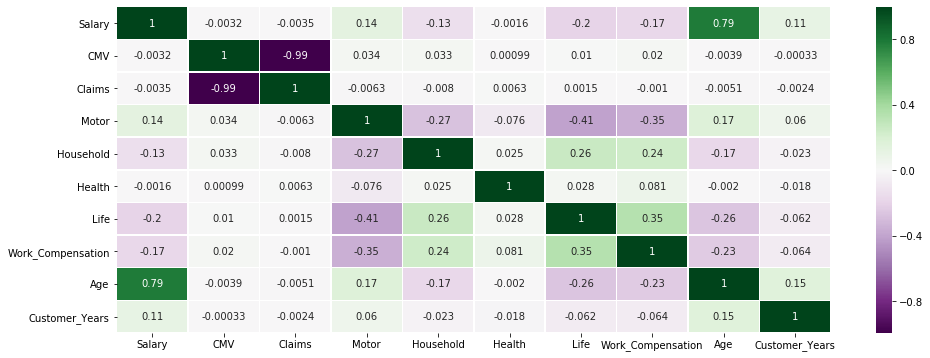

In [11]:
corr = df.corr(method='pearson')

# Obtain Correlation and plot it
plt.figure(figsize=(16,6))

h_map = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='PRGn', annot=True, linewidths=.5)

#this is fix for matplotlib3.1.1 to ensure the top and bottom rows are not cut off.
# According to: https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [12]:
# might be handy: https://github.com/joaolcorreia/RFM-analysis

In [13]:
df.head()

,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work_Compensation,Age,Customer_Years
ID,,,,,,,,,,,,,
1,nan,2177.00,1.00,1.00,380.97,0.39,375.85,79.45,146.36,47.01,16.89,34.00,31.00
2,nan,677.00,4.00,1.00,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,21.00,29.00
3,nan,2277.00,3.00,0.00,504.67,0.28,206.15,224.50,124.58,86.35,99.02,46.00,25.00
4,nan,1099.00,4.00,1.00,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,35.00,26.00
5,nan,1763.00,4.00,1.00,35.23,0.90,338.62,47.80,182.59,18.78,41.45,43.00,30.00


In [14]:
from sklearn.preprocessing import StandardScaler
df[:] = StandardScaler().fit_transform(df[:])

x = df[df.columns.difference(categorical_cols + premiums_cols)].values # excluding categorical columns
x = x[:200] # slice array for faster cluster testing
x

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


array([[-1.20911431e-01],
       [ 1.29324807e-01],
       [-1.58618261e-01],
       [ 8.47621891e-02],
       [ 5.39111461e-02],
       [ 8.81900828e-02],
       [ 1.05329551e-01],
       [ 1.32752700e-01],
       [-1.31195112e-01],
       [ 1.29324807e-01],
       [-7.29209196e-02],
       [-9.69161753e-02],
       [ 7.79064018e-02],
       [ 1.08757445e-01],
       [ 1.29324807e-01],
       [-7.29209196e-02],
       [ 5.04832524e-02],
       [ 3.67716778e-02],
       [-1.12188336e-02],
       [-1.31195112e-01],
       [-1.20911431e-01],
       [ 1.96322094e-02],
       [ 1.15613232e-01],
       [-3.52140892e-02],
       [ 2.30601031e-02],
       [-1.14055644e-01],
       [-1.24339325e-01],
       [ 7.79064018e-02],
       [-8.32046006e-02],
       [ 7.44785081e-02],
       [-1.89469304e-01],
       [-1.80746209e-02],
       [ 7.44785081e-02],
       [ 7.79064018e-02],
       [-9.00603879e-02],
       [ 5.04832524e-02],
       [ 6.76227208e-02],
       [ 9.16179764e-02],
       [ 8.1

In [15]:
from sklearn.decomposition import PCA

# Fitting the PCA algorithm with our Data
pca = PCA().fit(df)

print(pca.explained_variance_ratio_)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.grid()
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

9 components explain 94.20951% of the variance. So, we'll use 9 components.

In [ ]:
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(df)

principalDf = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6',
                                                                  'pc_7', 'pc_8', 'pc_9'])

In [ ]:
print('Components: ', pca.components_)
print('Explained Variance: ', pca.explained_variance_)
print('Explained Variance Ratio: ', pca.explained_variance_ratio_)

In [ ]:
principalDf.head(5)

In [ ]:
# # do we need to show the PCA some how? so I try to do with T-SNE
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
# tsne_pca_results = tsne.fit_transform(principalDf)

# tsne_data = np.vstack((tsne_pca_results.T, principalDf.index)).T

# tsne_df = pd.DataFrame(data=tsne_data, columns = ('Dim_1', 'Dim_2', 'label'))

# sns.FacetGrid(tsne_df, hue='label', height=6).map(plt.scatter, 'Dim_1', 'Dim_2', alpha=.7)
# plt.show()

In [ ]:
# df_subset = df.copy()
# df_subset = df_subset.T
# df_subset['tsne-pca-one'] = tsne_pca_results[:,0]
# df_subset['tsne-pca-two'] = tsne_pca_results[:,1]

# ax = plt.subplot(1,3,3)
# sb.scatterplot(
#     x='tsne-pca-one', y='tsne-pca-one',
#     hue=df.columns,
#     palette=sb.color_palette('hls', 10),
#     data = df_subset,
#     legend = 'full',
#     alpha = 0.3
# )

In [ ]:
sns.pairplot(principalDf)
plt.show()

In [ ]:
# only if PCA is 2 components:
# plt.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1])
# # plt.scatter(principalComponents[:,0], principalComponents[:,1])
# plt.show()

In [ ]:
# principalDf = StandardScaler().fit_transform(principalDf[:])

# x = principalDf.values

# x.shape

In [ ]:
from utils.preprocessing import remove_outliers, handle_nans

_, pca_outliers = remove_outliers(principalDf, principalDf.columns)
print(pca_outliers, "\n")

i = 1

while pca_outliers.any() == True: # checking non-zero existence
    print(f"Iteration #{i}...")
    principalDf, pca_outliers = remove_outliers(principalDf, pca_outliers[pca_outliers > 0].index.tolist())
    principalDf = handle_nans(principalDf, pca_outliers[pca_outliers > 0].index.tolist())
    principalDf[:] = StandardScaler().fit_transform(principalDf[:])
    i += 1

print("No outliers after standardization.")

In [ ]:
sns.pairplot(principalDf)
plt.show()

In [ ]:
# Fitting the PCA algorithm with our Data
pca = PCA().fit(principalDf)

print(pca.explained_variance_ratio_)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.grid()
plt.show()

In [ ]:
pca = PCA(n_components=2)
secondComponents = pca.fit_transform(principalDf)

secondDf = pd.DataFrame(data = secondComponents, columns = ['pc_1', 'pc_2'])

In [ ]:
x = secondComponents

x.shape

### K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#data
df_forClus


plt.figure(figsize=(10, 7))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_forClus)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
best_number_of_clusters = 5

In [ ]:
kmeans = KMeans(n_clusters=best_number_of_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df_forClus)
#plt.scatter(df_forClus[:,0], df_forClus[:,1])
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
#plt.show()



In [ ]:
pred_y

In [ ]:
n_clusters = 3

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X.iloc[:, 0]
    ys = X.iloc[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

silplot(df_forClus, kmeans)
plt.show()

In [ ]:
df_forClus.iloc[:, 0]
df_forClus.iloc[:, 1]

In [ ]:
# Awful results. However, agglomerative clustering seems to be better.

### Agglomerative Clustering

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(df_forClus, method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 5

cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_forClus)

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(df_forClus.iloc[:,0], df_forClus.iloc[:,1], c=cluster.labels_, cmap='rainbow')

plt.show()

In [ ]:
df_cat = df_forClus[['Education', 'Area', 'Children']]

In [ ]:
df_cat

In [ ]:
# define the k-modes model
km = KModes(n_clusters=10, init='Huang', n_init=11, verbose=1)

clusters = km.fit_predict(df_cat)

# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape
